# IMPORT

In [27]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
import graphviz

# Tải dataset Heart Disease từ UCI

In [28]:
heart_disease = fetch_ucirepo(id=45)

# Tách dữ liệu và nhãn

In [29]:
X = heart_disease.data.features
y = heart_disease.data.targets
y = np.where(y == 0, 0, 1)

# Chọn chia dữ liệu train/test (ví dụ 80% train, 20% test) với stratify và shuffle

In [61]:
test_size_options = [0.1, 0.2, 0.4, 0.6]

print("#1 train/test = 90/10")
print("#2 train/test = 80/20")
print("#3 train/test = 60/40")
print("#4 train/test = 40/60")

pick = input("Pick a proportion (1-4): #")
test_size = test_size_options[int(pick) - 1]
print(f"-> train/test = {100 - int(test_size*100)}/{int(test_size*100)}")

test_size = test_size_options[i]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42
)

#1 train/test = 90/10
#2 train/test = 80/20
#3 train/test = 60/40
#4 train/test = 40/60


Pick a proportion (1-4): # 1


-> train/test = 90/10


# Huấn luyện Decision Tree (dùng information gain → criterion="entropy")

In [62]:
clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

# Dự đoán trên tập test

In [63]:
y_pred = clf.predict(X_test)

# Báo cáo đánh giá mô hình

Classification Report:
              precision    recall  f1-score   support

 No Diseases       0.88      0.67      0.76        33
    Diseases       0.69      0.89      0.78        28

    accuracy                           0.77        61
   macro avg       0.79      0.78      0.77        61
weighted avg       0.79      0.77      0.77        61



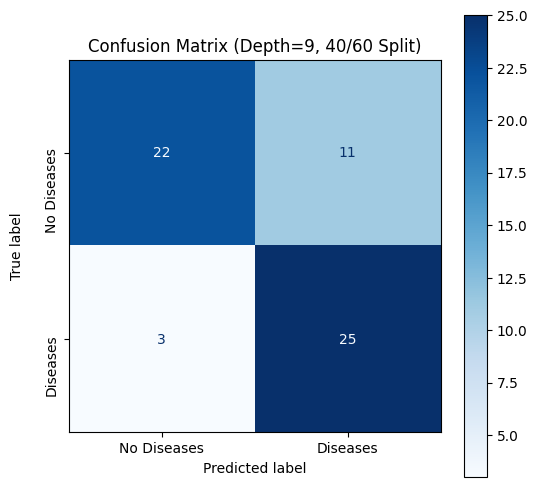

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Gán tên class
target_names = ["No Diseases", "Diseases"]

# Classification report -----------------------------------------------------------------------------------------
print("Classification Report:")
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)

# Confusion matrix ----------------------------------------------------------------------------------------------
class_labels = [0, 1]  # hoặc np.unique(y_test) nếu chắc chỉ có 0,1
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format='d')

# 👉 Xoay nhãn trục y
plt.setp(ax.get_yticklabels(), rotation=90)

# 👉 Tăng khoảng cách giữa nhãn "True label" và trục y
ax.set_ylabel("True label", labelpad=15)

plt.title(f"Confusion Matrix (Depth={clf.get_depth()}, {100 - int(test_size*100)}/{int(test_size*100)} Split)")
plt.grid(False)
plt.show()

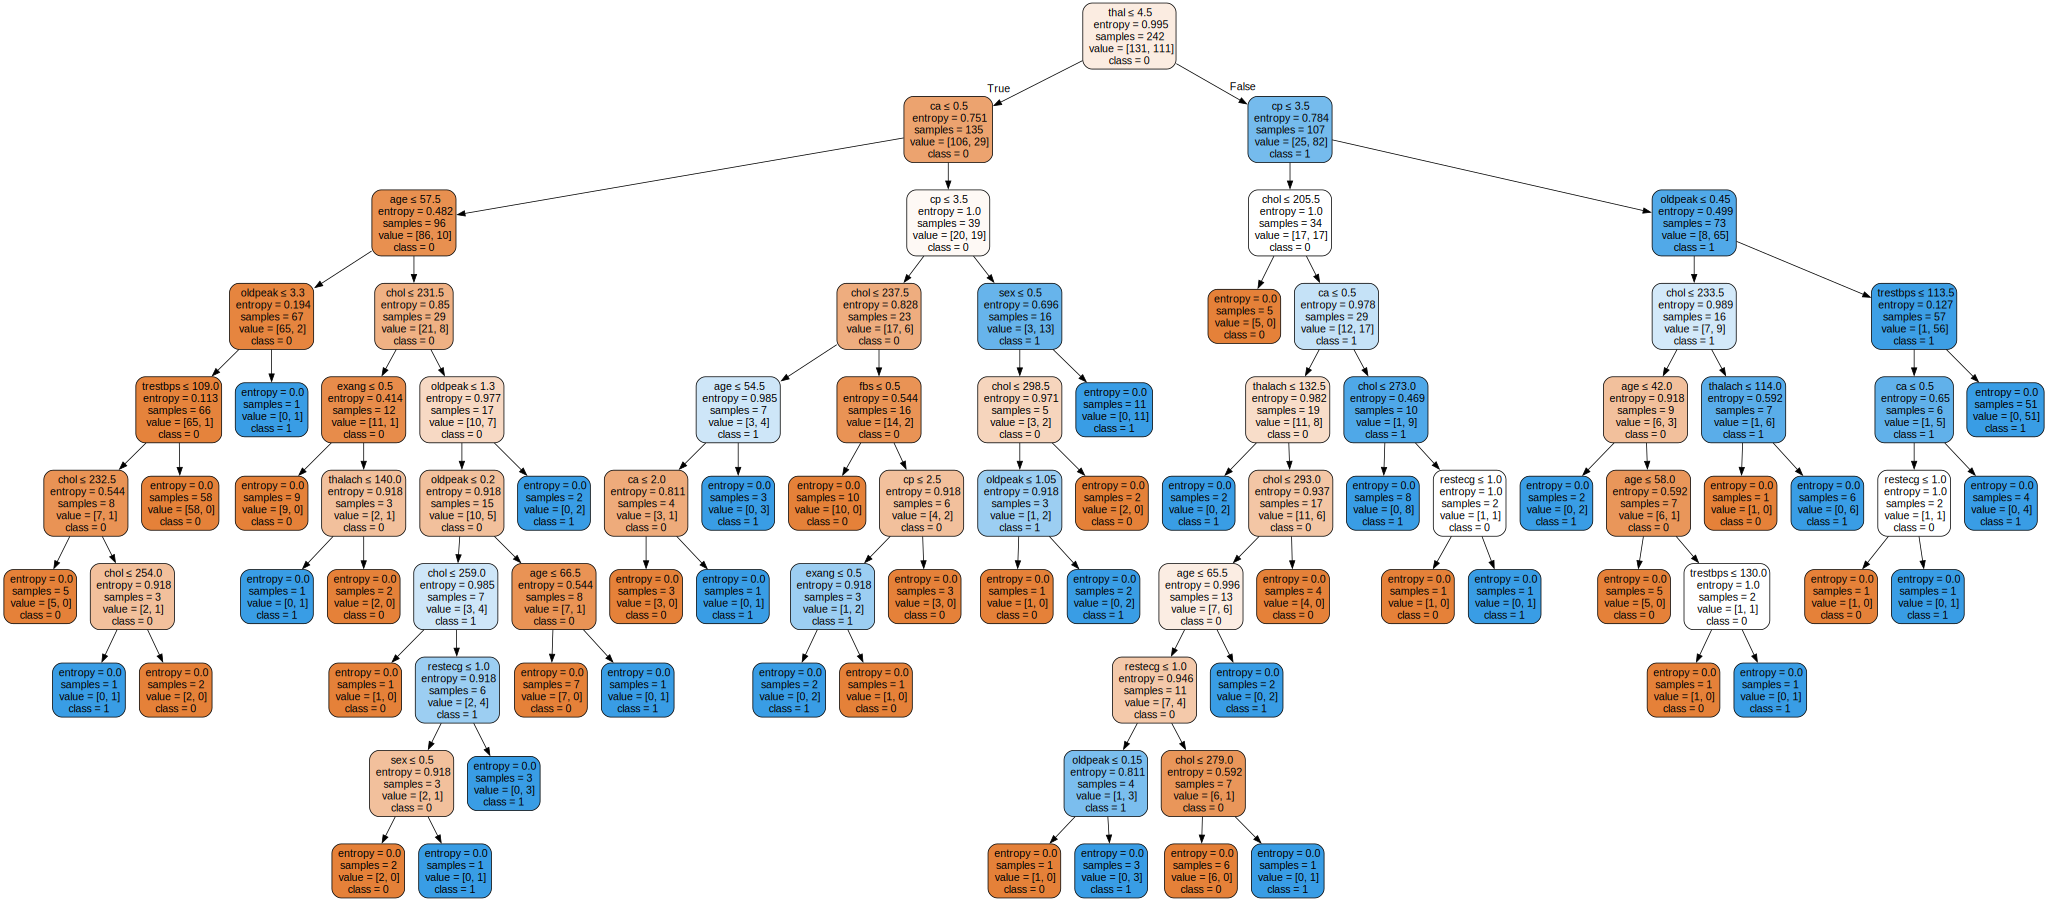

In [53]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=X.columns,
    class_names=[str(c) for c in clf.classes_],
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
display(graph)  # hoạt động ngon lành trong Jupyter